<a href="https://colab.research.google.com/github/srushtidayanand/MAML_Meta-learning/blob/main/GAN_MAML_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch  # Core PyTorch library
import torch.nn as nn  # Neural network modules (layers, loss functions)
import torch.optim as optim  # Optimizers like SGD, Adam
import torchvision.transforms as transforms  # Image preprocessing tools
from torchvision.datasets import MNIST  # MNIST dataset (handwritten digits)
from torch.utils.data import DataLoader, Subset  # For batching and dataset splitting
import numpy as npa  # NumPy for array operations (alias `npa`)
import matplotlib.pyplot as plt  # Plotting library
from tqdm import tqdm  # Progress bar for loops


In [ ]:
# Set device to GPU if available, else fallback to CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")  # Print the selected device


Using device: cpu


In [ ]:
import torch
import torch.nn as nn

# Improved CNN-based Generator for 28x28 images
class CNNGenerator(nn.Module):
    def __init__(self, latent_dim=128):
        super(CNNGenerator, self).__init__()
        self.latent_dim = latent_dim

        # Fully Connected block: z → (128 x 7 x 7)
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 256 * 7 * 7),  # More channels for richer feature maps
            nn.BatchNorm1d(256 * 7 * 7),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3)  # helps prevent mode collapse
        )

        # Deconvolution blocks
        self.deconv = nn.Sequential(
            # Upsample: 7x7 → 14x14
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            # Upsample: 14x14 → 28x28
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            # Final layer: produce 1 channel image
            nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )

        # Apply custom weight initialization
        self.apply(self._weights_init)

    def _weights_init(self, m):
        if isinstance(m, (nn.ConvTranspose2d, nn.Conv2d, nn.Linear)):
            nn.init.xavier_uniform_(m.weight)  # DCGAN recommended init
            if m.bias is not None:
                nn.init.zeros_(m.bias)

    def forward(self, z):
        x = self.fc(z)                          # (batch_size, 256*7*7)
        x = x.view(z.size(0), 256, 7, 7)        # reshape to (batch_size, 256, 7, 7)
        img = self.deconv(x)                    # → (batch_size, 1, 28, 28)
        return img


In [ ]:
import torch.nn as nn
import torch.nn.utils as nn_utils

class CNNDiscriminator(nn.Module):
    def __init__(self):
        super(CNNDiscriminator, self).__init__()

        # === Feature Extractor ===
        self.features = nn.Sequential(
            # (1, 28, 28) → (64, 14, 14)
            nn_utils.spectral_norm(nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),  # prevent overfitting

            # (64, 14, 14) → (128, 7, 7)
            nn_utils.spectral_norm(nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),

            # Extra layer: (128, 7, 7) → (256, 7, 7) (no downsampling, richer features)
            nn_utils.spectral_norm(nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3)
        )

        # === Classifier ===
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 7 * 7, 1),
            nn.Sigmoid()
        )

        # Apply DCGAN-style weight initialization
        self.apply(self._weights_init)

    def _weights_init(self, m):
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)

    def forward(self, x):
        features = self.features(x)      # Extract features
        validity = self.classifier(features)  # Real/fake probability
        return validity


In [ ]:
!pip install higher

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 107.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 77.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import higher  # for differentiable inner loop
from copy import deepcopy
class MAML_GAN:
    def __init__(self, latent_dim=128, inner_lr=0.012, meta_lr=0.0012):
        self.latent_dim = latent_dim
        self.inner_lr = inner_lr
        self.meta_lr = meta_lr

        self.generator = CNNGenerator(latent_dim).to(device)
        self.discriminator = CNNDiscriminator().to(device)

        # Meta-optimizers (outer loop)
        self.meta_opt_G = optim.Adam(self.generator.parameters(), lr=self.meta_lr)
        self.meta_opt_D = optim.Adam(self.discriminator.parameters(), lr=self.meta_lr)

        self.loss_fn = nn.BCEWithLogitsLoss()


    def inner_loop(self, gen, disc, loader, steps=2):
        """ Differentiable inner loop using higher """
        opt_G = optim.SGD(gen.parameters(), lr=self.inner_lr)
        opt_D = optim.SGD(disc.parameters(), lr=self.inner_lr)

        # Create functional versions that allow gradient flow
        with higher.innerloop_ctx(gen, opt_G, copy_initial_weights=False) as (fgen, diffopt_G), \
             higher.innerloop_ctx(disc, opt_D, copy_initial_weights=False) as (fdisc, diffopt_D):

            for _ in range(steps):
                real_imgs, _ = next(iter(loader))
                real_imgs = real_imgs.to(device)
                batch_size = real_imgs.size(0)

                # ======== Discriminator update ========
                z = torch.randn(batch_size, self.latent_dim).to(device)
                fake_imgs = fgen(z).detach()

                real_labels = torch.ones(batch_size, 1).to(device)
                fake_labels = torch.zeros(batch_size, 1).to(device)

                real_loss = self.loss_fn(fdisc(real_imgs), real_labels)
                fake_loss = self.loss_fn(fdisc(fake_imgs), fake_labels)
                d_loss = real_loss + fake_loss

                diffopt_D.step(d_loss)

                # ======== Generator update ========
                z = torch.randn(batch_size, self.latent_dim).to(device)
                fake_imgs = fgen(z)
                g_loss = self.loss_fn(fdisc(fake_imgs), real_labels)

                diffopt_G.step(g_loss)

            # Return adapted functional models
            return fgen, fdisc

    def outer_loop(self, tasks, inner_steps=10, meta_steps=70):
        """ Pure MAML outer loop """
        for step in range(meta_steps):
            self.meta_opt_G.zero_grad()
            self.meta_opt_D.zero_grad()

            total_meta_loss_G = 0.0

            for task_loader in tasks:
                # Inner loop adaptation
                fgen, fdisc = self.inner_loop(self.generator, self.discriminator, task_loader, steps=inner_steps)

                # ======== Meta-loss computation ========
                z = torch.randn(32, self.latent_dim).to(device)
                fake_imgs = fgen(z)
                pred = fdisc(fake_imgs)
                meta_loss_G = self.loss_fn(pred, torch.ones_like(pred))

                # Accumulate gradients
                meta_loss_G.backward()
                total_meta_loss_G += meta_loss_G.item()

            # Outer loop update
            self.meta_opt_G.step()
            self.meta_opt_D.step()

            if step % 5 == 0:
                print(f"[Meta Step {step}] Avg Meta Generator Loss: {total_meta_loss_G/len(tasks):.4f}")

    def adapt_to_digit_9(self, loader, steps=250):
        print("Adapting to digit 9 with fine-tuning...")
        self.generator, self.discriminator = self._finetune(self.generator, self.discriminator, loader, steps)

    def _finetune(self, gen, disc, loader, steps):
        """ Non-differentiable fine-tuning (for evaluation) """
        opt_G = optim.SGD(gen.parameters(), lr=self.inner_lr)
        opt_D = optim.SGD(disc.parameters(), lr=self.inner_lr)

        for _ in range(steps):
            real_imgs, _ = next(iter(loader))
            real_imgs = real_imgs.to(device)
            batch_size = real_imgs.size(0)

            z = torch.randn(batch_size, self.latent_dim).to(device)
            fake_imgs = gen(z).detach()

            real_labels = torch.ones(batch_size, 1).to(device)
            fake_labels = torch.zeros(batch_size, 1).to(device)

            real_loss = self.loss_fn(disc(real_imgs), real_labels)
            fake_loss = self.loss_fn(disc(fake_imgs), fake_labels)
            d_loss = real_loss + fake_loss

            opt_D.zero_grad()
            d_loss.backward()
            opt_D.step()

            z = torch.randn(batch_size, self.latent_dim).to(device)
            fake_imgs = gen(z)
            g_loss = self.loss_fn(disc(fake_imgs), real_labels)

            opt_G.zero_grad()
            g_loss.backward()
            opt_G.step()

        return gen, disc

    def generate(self, num_samples=25):
        z = torch.randn(num_samples, self.latent_dim).to(device)
        samples = self.generator(z)
        return samples.detach().cpu()


ModuleNotFoundError: No module named 'higher'

In [ ]:
from copy import deepcopy
# -----------------------------
# === Run MAML-GAN ===
# -----------------------------
if __name__ == '__main__':
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])

    dataset = MNIST(root='./data', train=True, transform=transform, download=True)

    # Create tasks: each task has samples from one digit class (0 to 8)
    tasks = []
    for digit in range(9):  # Digits 0 to 8
        indices = [i for i, (_, label) in enumerate(dataset) if label == digit]
        subset = Subset(dataset, indices[:])  # Use 200 samples per task
        loader = DataLoader(subset, batch_size=64, shuffle=True)
        tasks.append(loader)

    # Create separate loader for digit 9
    indices_9 = [i for i, (_, label) in enumerate(dataset) if label == 9]
    subset_9 = Subset(dataset, indices_9[:10])  # Few-shot digit 9
    loader_9 = DataLoader(subset_9, batch_size=64, shuffle=True)

    # Initialize model and train
    gan = MAML_GAN()
    gan.outer_loop(tasks, inner_steps=10, meta_steps=800)

    # Adapt to digit 9
    gan.adapt_to_digit_9(loader_9, steps=150)

    # Generate samples
    samples = gan.generate(10)

    # Plot generated images
    samples = [img.squeeze(0) for img in samples]
    grid = torch.cat(samples, dim=1)
    plt.figure(figsize=(15, 2))
    plt.imshow(grid.numpy(), cmap='gray')
    plt.title("Generated Digit 9 Samples After MAML Adaptation")
    plt.axis('off')
    plt.show()

100%|██████████| 9.91M/9.91M [00:00<00:00, 11.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 344kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 2.72MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.89MB/s]


[Meta Step 0] Avg Meta Generator Loss: 0.6322
[Meta Step 5] Avg Meta Generator Loss: 0.3133
[Meta Step 10] Avg Meta Generator Loss: 0.3133


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 90.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 42.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.9/981.9 kB 46.8 MB/s eta 0:00:00
Using device: cuda


100%|██████████| 9.91M/9.91M [00:02<00:00, 4.55MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.26MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.57MB/s]



Starting True Second-Order MAML Training...

[Epoch 1/25] D_meta_loss: 0.1241, G_meta_loss: 2.5063
[Epoch 2/25] D_meta_loss: 0.0205, G_meta_loss: 4.7733
[Epoch 3/25] D_meta_loss: 0.0862, G_meta_loss: 2.9645
[Epoch 4/25] D_meta_loss: 0.0078, G_meta_loss: 7.8227
[Epoch 5/25] D_meta_loss: 0.0003, G_meta_loss: 13.2335
[Epoch 6/25] D_meta_loss: 0.0005, G_meta_loss: 16.2554
[Epoch 7/25] D_meta_loss: 0.0805, G_meta_loss: 2.8572
[Epoch 8/25] D_meta_loss: 0.0002, G_meta_loss: 14.4629
[Epoch 9/25] D_meta_loss: 0.0008, G_meta_loss: 18.0746
[Epoch 10/25] D_meta_loss: 0.0070, G_meta_loss: 12.9925
[Epoch 11/25] D_meta_loss: 0.0039, G_meta_loss: 13.2046
[Epoch 12/25] D_meta_loss: 0.0054, G_meta_loss: 10.0993
[Epoch 13/25] D_meta_loss: 0.0113, G_meta_loss: 7.1711
[Epoch 14/25] D_meta_loss: 0.0602, G_meta_loss: 4.5608
[Epoch 15/25] D_meta_loss: 0.1986, G_meta_loss: 3.1364
[Epoch 16/25] D_meta_loss: 0.3568, G_meta_loss: 2.6353
[Epoch 17/25] D_meta_loss: 0.6258, G_meta_loss: 3.5544
[Epoch 18/25] D_meta_

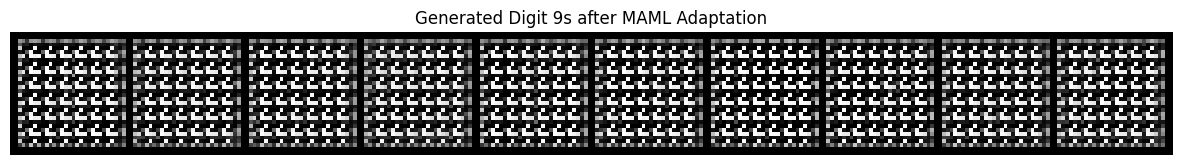

ModuleNotFoundError: FrechetInceptionDistance metric requires that `Torch-fidelity` is installed. Either install as `pip install torchmetrics[image]` or `pip install torch-fidelity`.

In [ ]:
# ✅ Install dependencies
!pip install torch torchvision matplotlib tqdm torchmetrics higher --quiet

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, Subset
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import random, os, higher
from copy import deepcopy

# Metrics
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.inception import InceptionScore
from torchmetrics.image.kid import KernelInceptionDistance

# -------------------------------
# Device setup
# -------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# -------------------------------
# Generator (DCGAN style CNN)
# -------------------------------
class Generator(nn.Module):
    def __init__(self, z_dim=100, img_channels=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(z_dim, 128, 7, 1, 0, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, img_channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )
    def forward(self, z):
        return self.net(z)

# -------------------------------
# Discriminator (DCGAN style CNN)
# -------------------------------
class Discriminator(nn.Module):
    def __init__(self, img_channels=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(img_channels, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 1, 7, 1, 0, bias=False),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x).view(-1)

# -------------------------------
# Load MNIST
# -------------------------------
transform = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = MNIST(root="./data", train=True, download=True, transform=transform)
test_dataset = MNIST(root="./data", train=False, download=True, transform=transform)

def get_digit_indices(dataset, digit, max_samples=None):
    idx = [i for i, (_, y) in enumerate(dataset) if y == digit]
    if max_samples:
        idx = idx[:max_samples]
    return idx

# -------------------------------
# Training Parameters
# -------------------------------
z_dim = 100
inner_steps = 3
inner_lr = 0.01
outer_lr = 0.001
meta_epochs = 25
support_size_train = 64
support_size_test = 10

# Meta models
metaG = Generator(z_dim).to(device)
metaD = Discriminator().to(device)
meta_optimizer = optim.Adam(
    list(metaG.parameters()) + list(metaD.parameters()),
    lr=outer_lr, betas=(0.5, 0.999)
)
loss_fn = nn.BCELoss()

# -------------------------------
# Meta-training on digits 0–8
# -------------------------------
print("\nStarting True Second-Order MAML Training...\n")

for epoch in range(meta_epochs):
    g_meta_loss, d_meta_loss = 0, 0
    meta_optimizer.zero_grad()

    for digit in range(9):  # digits 0–8
        support_idx = get_digit_indices(train_dataset, digit, support_size_train)
        query_idx = get_digit_indices(test_dataset, digit, 64)

        support_loader = DataLoader(Subset(train_dataset, support_idx), batch_size=support_size_train)
        query_loader = DataLoader(Subset(test_dataset, query_idx), batch_size=len(query_idx))

        x_support, _ = next(iter(support_loader))
        x_query, _ = next(iter(query_loader))
        x_support, x_query = x_support.to(device), x_query.to(device)

        # Inner loop with higher
        inner_optG = optim.SGD(metaG.parameters(), lr=inner_lr)
        inner_optD = optim.SGD(metaD.parameters(), lr=inner_lr)

        with higher.innerloop_ctx(metaG, inner_optG, copy_initial_weights=False) as (fG, diff_optG), \
             higher.innerloop_ctx(metaD, inner_optD, copy_initial_weights=False) as (fD, diff_optD):

            for step in range(inner_steps):
                z = torch.randn(support_size_train, z_dim, 1, 1).to(device)
                fake = fG(z)
                real = x_support

                # Train D
                real_labels = torch.ones(real.size(0), device=device)
                fake_labels = torch.zeros(fake.size(0), device=device)
                d_real = fD(real)
                d_fake = fD(fake.detach())
                d_loss = loss_fn(d_real, real_labels) + loss_fn(d_fake, fake_labels)
                diff_optD.step(d_loss)

                # Train G
                z = torch.randn(support_size_train, z_dim, 1, 1).to(device)
                fake = fG(z)
                g_fake = fD(fake)
                g_loss = loss_fn(g_fake, torch.ones_like(g_fake))
                diff_optG.step(g_loss)

            # Query loss after adaptation
            z_q = torch.randn(len(x_query), z_dim, 1, 1).to(device)
            fake_q = fG(z_q)
            d_real_q = fD(x_query)
            d_fake_q = fD(fake_q)
            d_q_loss = loss_fn(d_real_q, torch.ones_like(d_real_q)) + \
                       loss_fn(d_fake_q, torch.zeros_like(d_fake_q))
            g_q_loss = loss_fn(fD(fake_q), torch.ones_like(d_fake_q))

            # Accumulate meta gradients (second-order!)
            (d_q_loss + g_q_loss).backward()

            d_meta_loss += d_q_loss.item()
            g_meta_loss += g_q_loss.item()

    meta_optimizer.step()
    print(f"[Epoch {epoch+1}/{meta_epochs}] D_meta_loss: {d_meta_loss/9:.4f}, G_meta_loss: {g_meta_loss/9:.4f}")

# -------------------------------
# Meta-testing on digit 9
# -------------------------------
print("\nMeta-testing on digit 9...\n")
support_idx = get_digit_indices(train_dataset, 9, support_size_test)
query_idx = get_digit_indices(test_dataset, 9, 64)

support_loader = DataLoader(Subset(train_dataset, support_idx), batch_size=support_size_test)
query_loader = DataLoader(Subset(test_dataset, query_idx), batch_size=len(query_idx))

x_support, _ = next(iter(support_loader))
x_query, _ = next(iter(query_loader))
x_support, x_query = x_support.to(device), x_query.to(device)

# Adapt meta-trained models to digit 9
G = deepcopy(metaG)
D = deepcopy(metaD)
optG = optim.Adam(G.parameters(), lr=inner_lr, betas=(0.5, 0.999))
optD = optim.Adam(D.parameters(), lr=inner_lr, betas=(0.5, 0.999))

for step in range(inner_steps):
    z = torch.randn(support_size_test, z_dim, 1, 1).to(device)
    fake = G(z)
    real = x_support
    d_real = D(real)
    d_fake = D(fake.detach())
    d_loss = loss_fn(d_real, torch.ones_like(d_real)) + loss_fn(d_fake, torch.zeros_like(d_fake))

    optD.zero_grad()
    d_loss.backward()
    optD.step()

    fake = G(z)
    g_loss = loss_fn(D(fake), torch.ones_like(D(fake)))
    optG.zero_grad()
    g_loss.backward()
    optG.step()

    print(f"Adapt Step {step+1}/{inner_steps} | D_loss: {d_loss.item():.4f} | G_loss: {g_loss.item():.4f}")

# -------------------------------
# Generate Digit 9 Samples
# -------------------------------
G.eval()
z = torch.randn(10, z_dim, 1, 1).to(device)
samples = G(z).cpu().detach()
grid = vutils.make_grid(samples, nrow=10, normalize=True)
plt.figure(figsize=(15,3))
plt.imshow(np.transpose(grid, (1,2,0)))
plt.axis("off")
plt.title("Generated Digit 9s after MAML Adaptation")
plt.show()

# -------------------------------
# Evaluation Metrics
# -------------------------------
fid = FrechetInceptionDistance(feature=64).to(device)
kid = KernelInceptionDistance(subset_size=50).to(device)
is_metric = InceptionScore().to(device)

fid.update(samples.to(device), real=False)
fid.update(x_query.to(device), real=True)
print("FID:", fid.compute().item())

kid.update(samples.to(device), real=False)
kid.update(x_query.to(device), real=True)
print("KID:", kid.compute()[0].item())

is_metric.update(samples.to(device))
print("Inception Score:", is_metric.compute()[0].item())